# Sample DEMs at ATL06SR Point Locations
________________________
### Steps:
* Plot temporal overlap of ICESat-2 flights and aerial lidar flights to determine snow-on data pairs
* Sample various rasters (snow-off DTM, snow-on DTMs, slope maps) at various resolutions (3m, 20m, 100m) at each ATL06SR point  

### Import necessary packages:

In [16]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.time import Time
import datetime
import pickle
import rasterio as rio
from geoviews import opts, tile_sources as gvts

# Import raster sampling functions written by Friedrich Knuth from UW-Cryo: 
# https://github.com/uw-cryo/raster_sampling/blob/master/friedrich/core.py
import core

In [5]:
%matplotlib inline

In [6]:
pd.set_option('display.max_columns', None)

### Define a funtion for calculating the day of the water year:

In [7]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

### Load Data:  

In [12]:
# Load ATL06-SR data:
atl06sr_gdf = pickle.load(open('../../data/atl06/tuolumne_all_sr-atl06-09282022_processed_wo-dems.pkl', 'rb'))
# Load geodataframe of ASO aquisition dates, which was created in AUX_dataclean.ipynb: 
aso_gdf = pickle.load(open('../../data/misc/aso_dates.pkl', 'rb')) 
# Load file of the study outline:
outline_gdf = pickle.load(open('../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
# Load CDEC data:
snwd = pickle.load(open('../data/CDEC/cdec_gdf.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6992/644408154.py:2: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  atl06sr_gdf = pickle.load(open('../../data/atl06/tuolumne_all_sr-atl06-09282022_processed_wo-dems.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6992/644408154.py:4: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  aso_gdf = pickle.load(open('../../data/misc/aso_dates.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6992/644408154.py:6: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  outline_gdf = pickle.load(open('../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))


## Plot time series for all ATL06-SR and Airborne Snow Observatory, Inc. (ASO) data acquisition dates:
Adapted from code written by David Shean. This plot is useful for determining temporally adjacent data that can be paired. 

In [72]:
atl06sr_gdf['site'] = 'tuolumne'
# Create a column that indicates the acquisition date of the ATL06SR data:
atl06sr_gdf['acqdate'] = atl06sr_gdf.index.date

In [71]:
df_list = [aso_gdf, atl06sr_gdf]

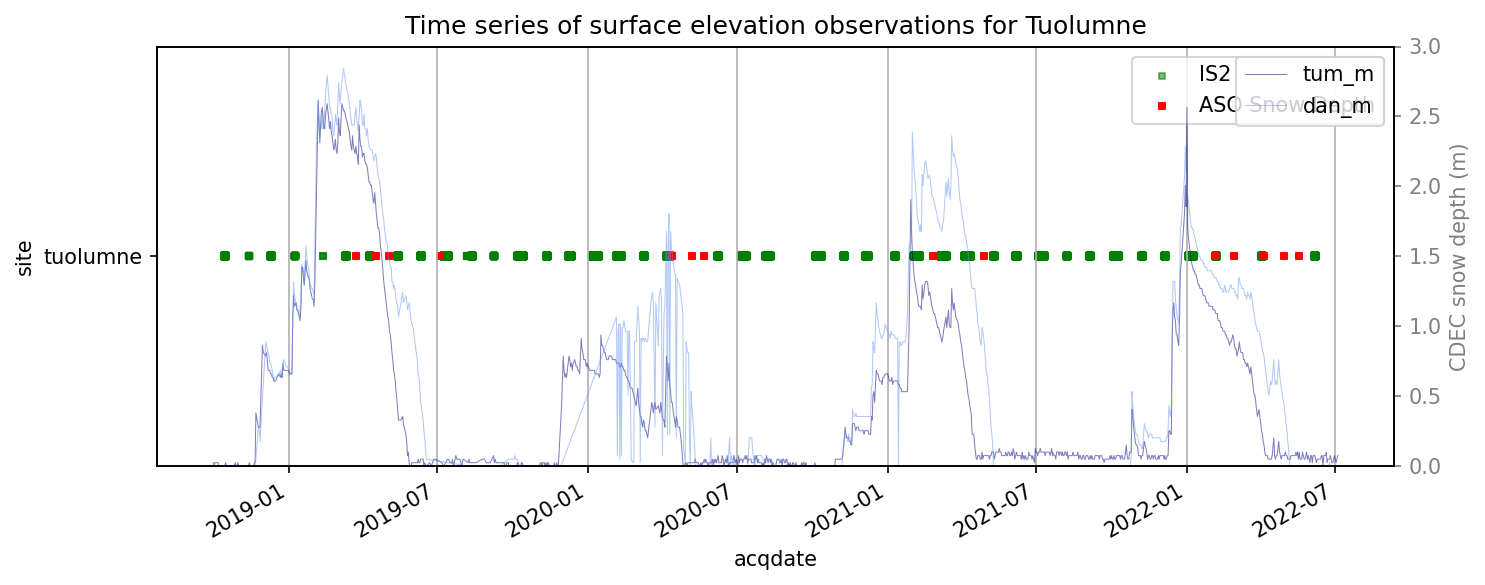

In [13]:
f, ax = plt.subplots(figsize=(10,4), dpi=150)
mykw = {'s':10, 'marker':'s', 'kind':'scatter'}

pd.DataFrame(df_list[1].drop(columns='geometry')).plot(ax=ax, alpha=0.5, x='acqdate', y='site', color='g', label='IS2', **mykw)
pd.DataFrame(df_list[0].drop(columns='geometry')).plot(ax=ax, x='acqdate', y='site', color='r', label='ASO Snow Depth', **mykw)

ax1 = ax.twinx()
snwd[snwd['tum_m'] < 2.9]['tum_m'].plot(ax=ax1, alpha=0.5, color='navy', lw=0.5, style='-')
snwd[snwd['dan_m'] < 2.9]['dan_m'].plot(ax=ax1, alpha=0.5, color='cornflowerblue', lw=0.5, style='-')
ax1.set_ylabel('CDEC snow depth (m)', color='gray')
ax1.tick_params(axis='y', colors='gray')
ax1.set_ylim(0,3)
plt.legend(loc='best')

#ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
f.autofmt_xdate()
ax.grid(axis='x', which='major')
ax.set_title('Time series of surface elevation observations for Tuolumne')
plt.tight_layout()
#plt.savefig('../../figures/timeseries.jpeg')

### List of alignable dates:  
Temporal offsets are between 2-17 days  
  
**ASO**       |     **IS2**  
[2019-03-24]  |   [2019-03-12]  
[2019-04-17]  |   [2019-04-10]  
[2019-05-03]  |   [2019-05-14]  
[2020-04-13]  |   [2020-04-07]  
[2020-05-22]  |   [2020-06-08]  
[2021-02-25]  |   [2021-02-08]  
[2022-02-04]  |   [2022-02-06]  
[2022-04-05]  |   [2022-04-03]

## Load Snow Off Digital Terrain Model (DTM)  
DTM was produced by ASO, as a composite of point clouds flown on Oct 10, 2019; 2014; and 2015.   

In [14]:
# Load snow-off DTM at 3 m resolution:
lidar_fn = '../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent.tif'

# Also load DTM that was upsampled to 20m resolution, to test whether resolution makes a difference:
lidar20_fn = '../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent_20m.tif'

In [17]:
lidar_snowoff_src = rio.open(lidar_fn)
lidar_snowoff20_src = rio.open(lidar20_fn)

In [18]:
lidar_snowoff_src.crs

CRS.from_epsg(32611)

## Sample snow-off DEM  
Using two different methods:  
1. The sample_raster function from David Shean. This uses nearest neighbor, which isn't the best interpolation method. The below function not only samples the DTM, but then computes the difference between the data using: **ICESat-2 - DTM**  
2. Using bicubic interopolation method written by Friedrich Knuth (UW) from https://github.com/uw-cryo/raster_sampling  
  
Then compare the two methods. Spoiler alert, bicubic is better. We originally used the first method, but ended up switching to the second method for the final version.

### 1) Nearest Neighbor

In [19]:
# This function written by David Shean, UW
# This function uses nearest neighbor, which is not ideal

def sample_raster(df, src, diff_col=None):
    #df_proj = df.to_crs(src.crs)
    coord = [(pt.x, pt.y) for pt in df.to_crs(src.crs).geometry]
    s = np.fromiter(src.sample(coord), dtype=src.dtypes[0])
    #s[s == src.nodata] = np.nan
    sm = np.ma.masked_equal(s, src.nodata)
    sample_colname = os.path.splitext(os.path.split(src.name)[-1])[0]
    df[sample_colname] = sm
    if diff_col is not None:
        out_colname = '{} {} diff'.format(diff_col, sample_colname)
        df[out_colname] = df[diff_col] - df[sample_colname]
    else:
        out_colname = sample_colname
    return out_colname

In [20]:
# Sample snow-off lidar at native resolution using nearest neighbor

atl06sr_diff_col = sample_raster(atl06sr_gdf, lidar_snowoff_src, diff_col='h_mean')
atl06sr_diff_col

'h_mean ASO_3M_PCDTM_USCATE_20191010_studyextent diff'

In [21]:
atl06sr_gdf = atl06sr_gdf.rename(columns={'ASO_3M_PCDTM_USCATE_20191010_studyextent':'lidar_z', 'h_mean ASO_3M_PCDTM_USCATE_20191010_studyextent diff':'difference'})

### 2) Bicubic Interpolation

In [22]:
coord = [(pt.x, pt.y) for pt in atl06sr_gdf.to_crs(lidar_snowoff_src.crs).geometry]

In [23]:
# This function was written by Friedrich Knuth, UW and is contained in core.py
# The sampling technique can be specified, here we use bicubic

bicubic_interp = core.interpolate(lidar_fn, coord, offset=3, kind='cubic')

In [60]:
bicubic_interp_20 = core.interpolate(lidar20_fn, coord, offset=3, kind='cubic')

In [61]:
atl06sr_gdf['bicubic_lidar_z_20'] = bicubic_interp_20

In [62]:
atl06sr_gdf['bicubic_lidar_z'] = bicubic_interp

### Comparison of the Sampling Methods:

In [63]:
atl06sr_gdf['sampling_dif'] = atl06sr_gdf['lidar_z'] - atl06sr_gdf['bicubic_lidar_z']

In [64]:
atl06sr_gdf['sampling_dif_20'] = atl06sr_gdf['bicubic_lidar_z_20'] - atl06sr_gdf['bicubic_lidar_z']

In [65]:
atl06sr_gdf['sampling_dif'].describe()

count    149275.000000
mean         -0.003077
std           0.522145
min         -50.586357
25%          -0.178886
50%          -0.001487
75%           0.178700
max           8.707335
Name: sampling_dif, dtype: float64

In [66]:
atl06sr_gdf['sampling_dif_20'].describe()

count    148435.000000
mean          0.011843
std           1.120343
min         -56.767428
25%          -0.412447
50%           0.007085
75%           0.436075
max          35.847460
Name: sampling_dif_20, dtype: float64

### Save the bicubic sampling, since it is time consuming to run:  
Uncomment if running for the first time

In [67]:
# atl06sr_out_fn = '../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic.pkl'

# with open(atl06sr_out_fn, 'wb') as f:
#     pickle.dump(atl06sr_gdf, f)

### And open this file again to continue working without having to rerun the bicubic methods:

In [56]:
#atl06sr_gdf = pickle.load(open('../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic.pkl', 'rb'))

### Calculate the difference between the ATL06-SR elevations and the bicubic-sampled snow-off lidar elevations:

In [68]:
atl06sr_gdf['difference_bicubic'] = atl06sr_gdf['h_mean'] - atl06sr_gdf['bicubic_lidar_z']
atl06sr_gdf['difference_bicubic'].describe()

count    149275.000000
mean          0.381722
std           1.724999
min         -60.102612
25%          -0.394637
50%           0.330723
75%           1.156059
max          69.654913
Name: difference_bicubic, dtype: float64

### Calculate the difference between the ATL06-SR elevations and the bicubic-sampled snow-off lidar elevations at 20m resolution

In [69]:
atl06sr_gdf['difference_bicubic_20m'] = atl06sr_gdf['h_mean'] - atl06sr_gdf['bicubic_lidar_z_20']
atl06sr_gdf['difference_bicubic_20m'].describe()

count    148435.000000
mean          0.370566
std           1.735830
min         -39.715265
25%          -0.429164
50%           0.325011
75%           1.166431
max          63.837178
Name: difference_bicubic_20m, dtype: float64

^ These differences include snow on data. They differ only slightly depending on the resolution of the snow off lidar data

## Remove acquisition dates with N < 30  
Some dates have limited ATL06-SR data due to factors such as: the ICESat-2 track was near the edge of the study area, it was a cloudy day so fewer photons reached the surface, etc.

In [12]:
#atl06sr_gdf = pickle.load(open('../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))

In [42]:
#atl06sr_gdf.head()

In [73]:
atl06sr_gdf['n'] = atl06sr_gdf.groupby('acqdate')['acqdate'].transform('count')

In [74]:
atl06sr_gdf = atl06sr_gdf[atl06sr_gdf['n'] > 30]

## Filter Outliers, using the difference between the ATL06-SR data and the bicubic sampled snow-off lidar data  

In [75]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['difference_bicubic'] - atl06sr_gdf['difference_bicubic'].mean()) / atl06sr_gdf['difference_bicubic'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [76]:
# trying to get different zscore values for snow on versus snow off values

atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['difference_bicubic'].abs() <=absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['difference_bicubic'].abs() <=absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

## Remove Offset Between Datasets  
* ICESat-2 is measuring the ground surface as slightly below the surface of the DEM.
* **Question:** What resolution for the snow off data? Highest resolution looks better, but is it acceptible to use different resolution data?

In [77]:
atl06sr_gdf = atl06sr_gdf.assign(diff_plus = atl06sr_gdf['difference'] - atl06sr_gdf.loc[inner_snowoff_idx,'difference'].median()) 
atl06sr_gdf[inner_snowoff_idx]['diff_plus'].describe()

count    62807.000000
mean         0.015643
std          1.307803
min         -9.562715
25%         -0.585667
50%          0.000000
75%          0.658105
max         10.577444
Name: diff_plus, dtype: float64

In [78]:
atl06sr_gdf = atl06sr_gdf.assign(diff_plus_bicubic = atl06sr_gdf['difference_bicubic'] - atl06sr_gdf.loc[inner_snowoff_idx,'difference_bicubic'].median()) 
atl06sr_gdf[inner_snowoff_idx]['diff_plus_bicubic'].describe()

count    62807.000000
mean         0.007424
std          1.241012
min         -4.690045
25%         -0.574058
50%          0.000000
75%          0.634039
max          5.086821
Name: diff_plus_bicubic, dtype: float64

In [79]:
atl06sr_gdf = atl06sr_gdf.assign(diff_plus_bicubic_20m = atl06sr_gdf['difference_bicubic_20m'] - atl06sr_gdf.loc[inner_snowoff_idx,'difference_bicubic_20m'].median()) 
atl06sr_gdf[inner_snowoff_idx]['diff_plus_bicubic_20m'].describe()

count    62512.000000
mean        -0.007891
std          1.365506
min        -24.219139
25%         -0.610750
50%          0.000000
75%          0.649970
max         26.879656
Name: diff_plus_bicubic_20m, dtype: float64

Text(0.5, 1.0, '20m')

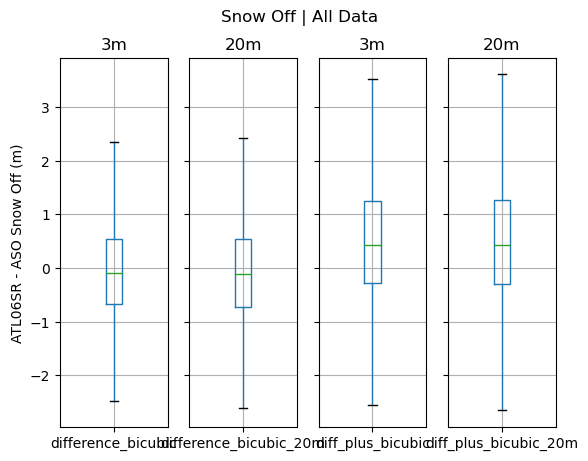

In [80]:
fig, ax = plt.subplots(1,4, sharey=True)
atl06sr_gdf[inner_snowoff_idx].boxplot(column=['difference_bicubic'], showfliers=False, ax=ax[0])
atl06sr_gdf[inner_snowoff_idx].boxplot(column=['difference_bicubic_20m'], showfliers=False, ax=ax[1])
atl06sr_gdf[atl06_idx].boxplot(column=['diff_plus_bicubic'], showfliers=False, ax=ax[2])
atl06sr_gdf[atl06_idx].boxplot(column=['diff_plus_bicubic_20m'], showfliers=False, ax=ax[3])
ax[0].set_ylabel('ATL06SR - ASO Snow Off (m)')
fig.suptitle('Snow Off | All Data')
ax[0].set_title('3m')
ax[1].set_title('20m')
ax[2].set_title('3m')
ax[3].set_title('20m')

Text(0.5, 1.0, 'bicubic')

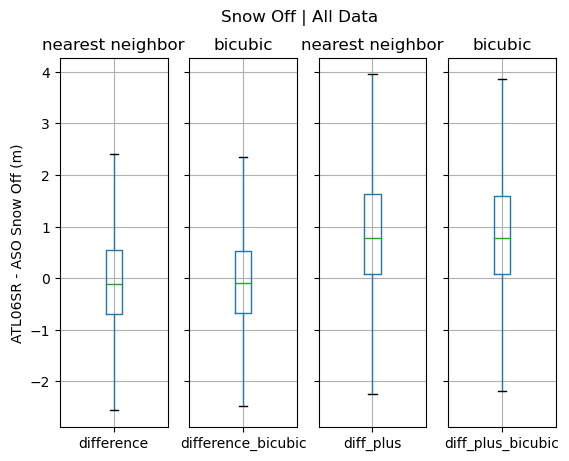

In [86]:
fig, ax = plt.subplots(1,4, sharey=True)
atl06sr_gdf[inner_snowoff_idx].boxplot(column=['difference'], showfliers=False, ax=ax[0])
atl06sr_gdf[inner_snowoff_idx].boxplot(column=['difference_bicubic'], showfliers=False, ax=ax[1])
atl06sr_gdf[inner_snowon_idx].boxplot(column=['diff_plus'], showfliers=False, ax=ax[2])
atl06sr_gdf[inner_snowon_idx].boxplot(column=['diff_plus_bicubic'], showfliers=False, ax=ax[3])
ax[0].set_ylabel('ATL06SR - ASO Snow Off (m)')
fig.suptitle('Snow Off | All Data')
ax[0].set_title('nearest neighbor')
#ax[0].set_xlabel('dif')
ax[1].set_title('bicubic')
#ax[1].set_xlabel('dif')
ax[2].set_title('nearest neighbor')
#ax[2].set_xlabel('dif_plus')
ax[3].set_title('bicubic')
#ax[3].set_xlabel('dif_plus')

## Sample snow-on ASO DEMs at 3m resolution  

### Date Pairs:  

**ASO**       |     **IS2**  
[2019-03-24]  |   [2019-03-12]  
[2019-04-17]  |   [2019-04-10]  
[2019-05-03]  |   [2019-05-14]  
[2020-04-13]  |   [2020-04-07]  
[2020-05-22]  |   [2020-06-08]  
[2021-02-25]  |   [2021-02-08]  
[2022-02-04]  |   [2022-02-06]  
[2022-04-05]  |   [2022-04-03]

In [87]:
# Make a list of all 
atl06_dates = [datetime.date(2019, 3, 12), 
              datetime.date(2019, 4, 10),
              datetime.date(2019, 5, 14),
              #datetime.date(2019, 7, 9),
              datetime.date(2020, 4, 7),
              datetime.date(2020, 6, 8),
              datetime.date(2021, 2, 8),
              datetime.date(2022, 2, 6),
              datetime.date(2022, 4, 3)]

In [106]:
aso_fn_dates = ['../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190324.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190417.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190503.tif',
                 #'../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190705.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_snowdepth_3m_20200413.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_snowdepth_3m_20200522.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_Mosaic_snowdepth_50m_20210225.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_Mosaic_snowdepth_3m_20220204.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_Mosaic_snowdepth_3m_20220405.tif']

## Nearest Neighbor sampling of ASO snow on data

In [107]:
# Adapted from David Shean's code
# not the original - changing to try and make applicable to specific dates of ASO/Is2 overlap

def sample_raster_dates(df, src, diff_col=None, date=datetime.date(2019, 3, 12)):
    #df_proj = df.to_crs(src.crs)
    coord = [(pt.x, pt.y) for pt in df.loc[df['acqdate'] == date].to_crs(src.crs).geometry]
    s = np.fromiter(src.sample(coord), dtype=src.dtypes[0])
    #s[s == src.nodata] = np.nan
    sm = np.ma.masked_equal(s, src.nodata)
    df.loc[df['acqdate'] == date, 'ASO_snowon'] = sm
    dt_str = os.path.splitext(os.path.split(src.name)[-1])[-2].split('_')[-1]
    df.loc[df['acqdate'] == date, 'ASO_snowon_date'] = datetime.datetime.strptime(dt_str, '%Y%m%d').date()

In [108]:
atl06sr_gdf['ASO_snowon'] = pd.Series(dtype=float)
atl06sr_gdf['ASO_snowon_date'] = pd.Series(dtype=float)

for file, date in zip(aso_fn_dates, atl06_dates):
    src = rio.open(file)
    sample_raster_dates(atl06sr_gdf, src, date=date)

## Bicubic sampling of ASO snow on data

In [109]:
atl06sr_gdf['ASO_snowon_bic'] = pd.Series(dtype=float)


for file, date in zip(aso_fn_dates, atl06_dates):
    src = rio.open(file)
    coord = [(pt.x, pt.y) for pt in atl06sr_gdf.loc[atl06sr_gdf['acqdate'] == date].to_crs(src.crs).geometry]
    bicubic_interp = core.interpolate(file, coord, offset=3, kind='cubic')
    atl06sr_gdf.loc[atl06sr_gdf['acqdate'] == date, 'ASO_snowon_bic'] = bicubic_interp

### Bicubic Interpolation of 20m Slope  

I made a 20m resolution version of the snow-off ASO DTM:  

gdalwarp -tr 20 20 -r cubic aso_file.tif aso_file_20m.tif  

And output a slope file from this using the following command line code:  
  
gdaldem slope aso_file_20m.tif aso_file_20m_slope.tif -co COMPRESS=LZW -co TILED=YES

In [ ]:
slope_fn_20m = '../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent_slope_20m.tif'
src_slo_20m = rio.open(slope_fn_20m)

In [27]:
coord = [(pt.x, pt.y) for pt in atl06sr_gdf.to_crs(src_slo_20m.crs).geometry]

In [28]:
# This function was written by Friedrich Knuth, UW and is contained in core.py
# The sampling technique can be specified, here we use bicubic

bicubic_interp = core.interpolate(slope_fn_20m, coord, offset=3, kind='cubic')

In [29]:
bicubic_interp

array([       nan,        nan, 1.78918874, ...,        nan,        nan,
              nan])

In [30]:
atl06sr_gdf['median_slope20d'] = bicubic_interp

## Save this version of the dataset:  
for use in analysis and figure-making notebooks (compare_to_cdec.ipynb, difference_maps.ipynb, pair_comparison.ipynb, etc.)

In [33]:
atl06sr_out_fn = '../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl'

with open(atl06sr_out_fn, 'wb') as f:
    pickle.dump(atl06sr_gdf, f)